# TF-IDF
As we have seen in the previous lesson, the deficiency of a mere word count obtained from the CountVectorizer is that large counts of certain common words may dilute the impact of more context specific words in the corpus. This is overcome by the TF-IDF vectorizer which penalizes words that appear several times across the documents. TF-IDF are word frequency scores that highlight words that are more important to the context rather than those that appear frequently across documents.

For that reason, the next step will be refining the word counts using the TF-IDF vectorizer.

**Note:** With the TfidfTransformer from sklearn, we can also use the previous CountVectorizer matrix and convert it into a TF-IDF matrix. 

N-grams will also be introduced in this notebook to try to improve the performance of the model.

## Data import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
amazon_df_train = pd.read_csv('dataset_amazon_train.csv')
amazon_df_test = pd.read_csv('dataset_amazon_test.csv')
#amazon_df_train = pd.read_csv('/Users/.../Desktop/dataset_amazon_train.csv')
#amazon_df_test = pd.read_csv('/Users/.../Desktop/dataset_amazon_test.csv')

In [3]:
amazon_df_train.head(5)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
amazon_df_train = pd.DataFrame(data=amazon_df_train, columns=['Score', 'Text'])
amazon_df_test = pd.DataFrame(data=amazon_df_test, columns=['Score', 'Text'])

In [5]:
amazon_df_train[40:43]

,Score,Text
40,5,The variety packs taste great!<br /><br />I ha...
41,5,McCann's makes oatmeal for every oatmeal conno...
42,5,I have McCann's Oatmeal every morning and by o...


# Data cleaning

In [6]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [7]:
from tqdm import tqdm
def clean(text_list, lemmatize, stemmer):
    
    updates = []
    
    for text in tqdm(text_list):
        
        # Lowercase text
        text = text.lower()
        
        # Remove unnecessary tags and all non-alphabetic characters
        text = re.sub("<br />", "", text)
        text = re.sub("[^a-zA-Z]"," ", text)
        
        # Remove stopwords
        text = " ".join([word for word in text.split() if word not in stop])
        
        # Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        # Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [8]:
updates = clean(amazon_df_train['Text'], lemmatize = True, stemmer = False)

100%|██████████| 75000/75000 [00:12<00:00, 6016.25it/s]


In [9]:
updates[40]

'variety pack taste great every morning cent per meal understand everyone earth buying stuff maple brown sugar terrific followed apple cinnamon followed regular get tired ole thing taste great boil water small pot empty packet bowl pour boiling water watch expand x size taste really good take minute prepare sure everyone earth convenient healthy quick excellent quality extremely cheap'

In [10]:
amazon_df_train['Text'][40]

"The variety packs taste great!<br /><br />I have them every morning. At $0.30 cents per meal, I don't understand why everyone on earth isn't buying this stuff up.<br /><br />Maple and brown sugar is terrific, followed by apples and cinnamon, followed by regular. You don't get tired of the same ole thing, and they taste great.<br /><br />I just boil water from a small pot, empty the packet or 2 in a bowl, pour in boiling water, and watch it expand to 2x its size!<br /><br />Taste really good and takes minutes to prepare.<br /><br />Not sure why everyone on earth isn't this. Convenient, healthy, very quick, excellent quality, and extremely cheap..."

In [11]:
amazon_df_train['Cleaned_Text'] = updates

In [12]:
amazon_df_train.head()

,Score,Text,Cleaned_Text
0,5,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...
2,4,This is a confection that has been around a fe...,confection around century light pillowy citrus...
3,2,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,5,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


# Define training features - Bag of Words (Bow)
Each word is a feature. Our feature space is defined by our vocabulary. Documents/pieces of text will be represented as sparse vectors.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
bow = CountVectorizer(binary=True)
X = bow.fit_transform(amazon_df_train["Cleaned_Text"])

In [15]:
X

<75000x45354 sparse matrix of type '<class 'numpy.int64'>'
	with 2462177 stored elements in Compressed Sparse Row format>

# Define labels

In [16]:
y = np.array(amazon_df_train['Score'])

In [17]:
y[0:10]

array([5, 1, 4, 2, 5, 4, 5, 5, 5, 5], dtype=int64)

In [18]:
len(y)

75000

# Train classifier

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [21]:
modelknn.fit(X,y)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

# Predict for test corpus

In [22]:
amazon_df_test['Cleaned_Text'] = clean(amazon_df_test['Text'], lemmatize = True, stemmer = False)

100%|██████████| 5000/5000 [00:00<00:00, 7206.12it/s]


In [23]:
X_test = bow.transform(amazon_df_test['Cleaned_Text'])
y_test = np.array(amazon_df_test['Score'])

In [24]:
y_pred = modelknn.predict(X_test)

# Evaluate

In [25]:
from sklearn.metrics import classification_report

In [33]:
labels = {"Very Bad":1, "Bad":2, "Neutral":3, "Good":4, "Very Good":5}
print(classification_report(y_test, y_pred, target_names = labels.keys()))

              precision    recall  f1-score   support

    Very Bad       0.69      0.21      0.32       470
         Bad       0.39      0.09      0.14       283
     Neutral       0.45      0.10      0.16       358
        Good       0.41      0.13      0.19       667
   Very Good       0.69      0.97      0.81      3222

    accuracy                           0.67      5000
   macro avg       0.53      0.30      0.33      5000
weighted avg       0.62      0.67      0.60      5000



In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[  99,   14,   12,   16,  329],
       [  15,   25,    8,   18,  217],
       [   7,    8,   35,   26,  282],
       [   6,   10,    3,   85,  563],
       [  16,    7,   19,   62, 3118]], dtype=int64)

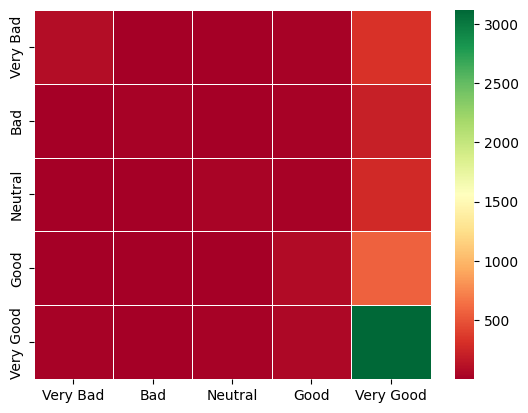

In [37]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), linewidth=0.5,cmap='RdYlGn')
ax.set_xticklabels(labels.keys())
ax.set_yticklabels(labels.keys())
plt.show()

# Define training features - TF-IDF

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
tfidf = TfidfVectorizer()

In [40]:
X = tfidf.fit_transform(amazon_df_train["Cleaned_Text"])

In [41]:
X[0]

<1x45354 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [42]:
df = pd.DataFrame(X[0].T.todense(), index=tfidf.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

               TF-IDF
appreciates  0.367009
vitality     0.342851
labrador     0.329545
product      0.290776
stew         0.283247
finicky      0.269444
better       0.254125
processed    0.240902
canned       0.210083
meat         0.197315
several      0.175038
look         0.165782
smell        0.164531
quality      0.155154
bought       0.139756
found        0.137483
dog          0.134991
food         0.122103
good         0.090469
like         0.084157
porray       0.000000
porno        0.000000
porky        0.000000
porta        0.000000
port         0.000000


# Train classifier

In [43]:
modelknn2 = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [44]:
modelknn2.fit(X,y)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

# Predict for test corpus

In [45]:
X_test = tfidf.transform(amazon_df_test['Cleaned_Text'])
y_test = np.array(amazon_df_test['Score'])

In [46]:
y_pred = modelknn2.predict(X_test)

# Evaluate

In [47]:
print(classification_report(y_test, y_pred, target_names = labels.keys()))

              precision    recall  f1-score   support

    Very Bad       0.54      0.23      0.33       470
         Bad       0.34      0.07      0.12       283
     Neutral       0.42      0.11      0.18       358
        Good       0.32      0.12      0.18       667
   Very Good       0.69      0.94      0.80      3222

    accuracy                           0.66      5000
   macro avg       0.46      0.30      0.32      5000
weighted avg       0.59      0.66      0.59      5000



In [44]:
confusion_matrix(y_test, y_pred)

array([[ 110,   23,   23,   15,   31],
       [  11,   20,    7,    7,   13],
       [  10,    4,   40,   21,   21],
       [  23,   18,   22,   82,  115],
       [ 316,  218,  266,  542, 3042]], dtype=int64)

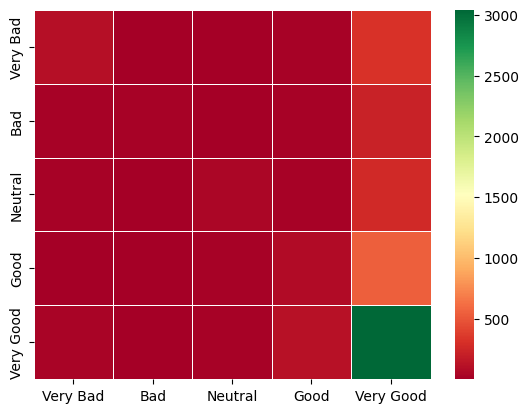

In [48]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), linewidth=0.5,cmap='RdYlGn')
ax.set_xticklabels(labels.keys())
ax.set_yticklabels(labels.keys())
plt.show()

# Define training features - TF-IDF with unigrams, bigrams and trigrams

In [49]:
ngram_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 3))
X_ngram = ngram_tfidf.fit_transform(amazon_df_train["Cleaned_Text"])

In [50]:
X_ngram

<75000x3357754 sparse matrix of type '<class 'numpy.float64'>'
	with 8103258 stored elements in Compressed Sparse Row format>

In [51]:
# Define training features - TF-IDF

# Train classifier

In [52]:
modelknn_ngram = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
modelknn_ngram.fit(X_ngram,y)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

# Predict for test corpus

In [53]:
X_test_ngram = ngram_tfidf.transform(amazon_df_test["Cleaned_Text"])

In [54]:
y_pred_ngram = modelknn_ngram.predict(X_test_ngram)

# Evaluate

In [55]:
print(classification_report(y_test, y_pred_ngram, target_names = labels.keys()))

              precision    recall  f1-score   support

    Very Bad       0.58      0.25      0.35       470
         Bad       0.36      0.07      0.12       283
     Neutral       0.34      0.10      0.15       358
        Good       0.35      0.13      0.19       667
   Very Good       0.70      0.95      0.80      3222

    accuracy                           0.66      5000
   macro avg       0.47      0.30      0.32      5000
weighted avg       0.59      0.66      0.59      5000



In [56]:
confusion_matrix(y_test, y_pred_ngram)

array([[ 117,   12,   11,   23,  307],
       [  26,   20,   10,   22,  205],
       [  17,    8,   35,   23,  275],
       [  10,    5,   15,   85,  552],
       [  30,   10,   33,   89, 3060]], dtype=int64)

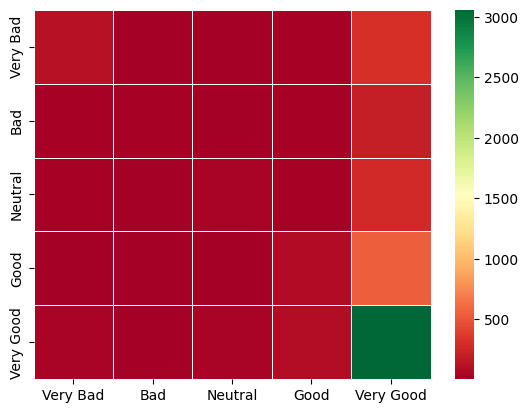

In [57]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred_ngram), linewidth=0.5,cmap='RdYlGn')
ax.set_xticklabels(labels.keys())
ax.set_yticklabels(labels.keys())
plt.show()